In [1]:
import pandas as pd
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Dense,RepeatVector,Dropout
from keras.layers import Flatten
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
from sklearn.preprocessing import MinMaxScaler


In [3]:
data = pd.read_csv('daily-website-visitors.csv')


In [4]:
data

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236
...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,8/15/2020,2221,1696,1373,323
2163,2164,Sunday,1,8/16/2020,2724,2037,1686,351
2164,2165,Monday,2,8/17/2020,3456,2638,2181,457
2165,2166,Tuesday,3,8/18/2020,3581,2683,2184,499


In [5]:
data = data.filter(['Page.Loads'])


In [6]:
# Lấy 100 dòng cuối cùng của df
data = data.tail(1000)
data

,Page.Loads
1167,2658
1168,2391
1169,3202
1170,4349
1171,4886
...,...
2162,2221
2163,2724
2164,3456
2165,3581


In [7]:
#Tiền xử lý
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
dataScale = scaler.fit_transform(data.values.reshape(-1,1))

In [8]:
# Hàm tính giá trị alpha tối ưu
def optimum_alpha(X):
    X_max = np.max(X)
    X_min = np.min(X)
    n = len(X)
    return ((X_max - X_min) - (1/n) * np.sum(X)) / (X_max - X_min)


In [9]:
def smoothed(X, alpha):
    S = np.zeros_like(X)
    S[0] = X[0]
    for i in range(1, len(X)):
        S[i] = S[i-1] + alpha*(X[i] - S[i-1])
    return S

In [10]:
alpha = optimum_alpha(dataScale)


In [11]:
S = smoothed(dataScale, alpha)
print("Giá trị alpha tối ưu:", alpha)
print("Chuỗi ban đầu:", dataScale)
print("Chuỗi đã được làm mịn:", S)


Giá trị alpha tối ưu: 0.5528196155001501
Chuỗi ban đầu: [[0.20006008]
 [0.15995795]
 [0.2817663 ]
 [0.45404025]
 [0.5346951 ]
 [0.48498047]
 [0.47326524]
 [0.33808952]
 [0.16581556]
 [0.31886452]
 [0.54505858]
 [0.47296485]
 [0.49098828]
 [0.46936017]
 [0.31420847]
 [0.19209973]
 [0.32397116]
 [0.49939922]
 [0.40597777]
 [0.44397717]
 [0.42234905]
 [0.42114749]
 [0.18849504]
 [0.30474617]
 [0.47401622]
 [0.48933614]
 [0.41754281]
 [0.30820066]
 [0.16821868]
 [0.01817363]
 [0.        ]
 [0.04250526]
 [0.17347552]
 [0.22108741]
 [0.22273956]
 [0.13367378]
 [0.03304296]
 [0.00195254]
 [0.05752478]
 [0.30985281]
 [0.3101532 ]
 [0.35626314]
 [0.32817663]
 [0.14313608]
 [0.2246921 ]
 [0.43766897]
 [0.44953439]
 [0.43526585]
 [0.37113247]
 [0.27996395]
 [0.10093121]
 [0.17858216]
 [0.39411235]
 [0.40657855]
 [0.44202463]
 [0.42024632]
 [0.28567137]
 [0.14433764]
 [0.24331631]
 [0.49294082]
 [0.51967558]
 [0.51036347]
 [0.46425353]
 [0.3385401 ]
 [0.15304896]
 [0.27696005]
 [0.53109042]
 [0.49

D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Download\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Smooth')

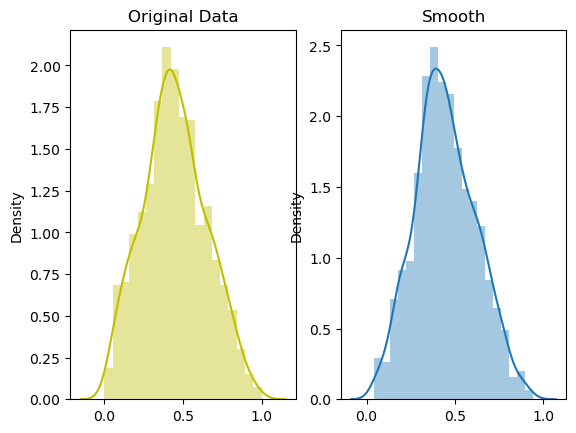

In [12]:
import seaborn as sns

fig, ax=plt.subplots(1,2)
sns.distplot(dataScale, ax=ax[0], color='y')
ax[0].set_title("Original Data")


sns.distplot(S,ax=ax[1])
ax[1].set_title("Smooth")


In [13]:
#Chia dữ liệu thành train test
data = pd.DataFrame(S)

#dataScale = data
train_percent = 0.8
train_size = int(len(data) * train_percent)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [14]:
#Chuẩn bị dữ liệu để đưa vào mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
          
       
        startWindow += stepWindow
    return np.array(X), np.array(y)


size_window = 7
size_predict = 1
stepWindow = 1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

In [15]:
start_time = time.time()

In [16]:

# Tạo mô hình CNN
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(size_window, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
for i in range(7):
    model.add(Dense(units=100, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

# Compile mô hình với Adam optimizer và Mean Squared Error loss
model.compile(loss='mse', optimizer='adam')


In [17]:
history = model.fit(X_train, y_train, epochs=10000, batch_size=16)

Epoch 1/10000
50/50 [==============================] - 2s 2ms/step - loss: 0.1000
Epoch 2/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 3/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 4/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 5/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 7/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 8/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 9/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 10/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 11/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 12/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 13/1000

50/50 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 100/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 101/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 102/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 103/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 104/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 105/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 106/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 107/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 108/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 109/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 110/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 11

50/50 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 197/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 198/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 199/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 200/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 201/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 202/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 203/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 204/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 205/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 206/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 207/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 20

50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 294/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 295/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 296/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 297/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 298/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 299/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 300/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 301/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 302/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 303/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 304/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 30

50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 391/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 392/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 393/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 394/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 395/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 396/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 397/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 398/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 399/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 400/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 401/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 40

50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 488/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 489/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 490/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 491/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 492/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 493/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 494/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 495/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 496/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 497/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 498/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 49

50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 585/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 586/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 587/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 588/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 589/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 590/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 591/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 592/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 593/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 594/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 595/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 59

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 682/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 683/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 684/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 685/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 686/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 687/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 688/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 689/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 690/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 691/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 692/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 69

50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 779/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 780/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 781/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 782/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7096e-04
Epoch 783/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 784/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 785/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 786/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 787/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 788/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 789/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5954e-04


50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 875/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3540e-04
Epoch 876/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9316e-04
Epoch 877/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0681e-04
Epoch 878/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4061e-04
Epoch 879/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3075e-04
Epoch 880/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 881/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 882/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 883/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8331e-04
Epoch 884/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 885/10000
50/50 [==============================] - 0s 2ms/step

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 971/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 972/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6958e-04
Epoch 973/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 974/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 975/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 976/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 977/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2787e-04
Epoch 978/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 979/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4896e-04
Epoch 980/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 981/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0

50/50 [==============================] - 0s 2ms/step - loss: 9.3063e-04
Epoch 1066/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1067/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1068/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1069/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1070/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1071/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0915e-04
Epoch 1072/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7931e-04
Epoch 1073/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1052e-04
Epoch 1074/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1075/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1076/10000
50/50 [==============================] - 0s 2ms/s

50/50 [==============================] - 0s 2ms/step - loss: 9.6838e-04
Epoch 1160/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1161/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2510e-04
Epoch 1162/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8415e-04
Epoch 1163/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1006e-04
Epoch 1164/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1165/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1166/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9805e-04
Epoch 1167/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3471e-04
Epoch 1168/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6832e-04
Epoch 1169/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1170/10000
50/50 [==============================

50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1253/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7280e-04
Epoch 1254/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5912e-04
Epoch 1255/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8794e-04
Epoch 1256/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1257/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1258/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1138e-04
Epoch 1259/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6044e-04
Epoch 1260/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7921e-04
Epoch 1261/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9571e-04
Epoch 1262/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4769e-04
Epoch 1263/10000
50/50 [==========================

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1346/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0266e-04
Epoch 1347/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2929e-04
Epoch 1348/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1349/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9248e-04
Epoch 1350/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7400e-04
Epoch 1351/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5777e-04
Epoch 1352/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1353/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5758e-04
Epoch 1354/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4677e-04
Epoch 1355/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5214e-04
Epoch 1356/10000
50/50 [==========================

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1439/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1440/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8291e-04
Epoch 1441/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6284e-04
Epoch 1442/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4861e-04
Epoch 1443/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3147e-04
Epoch 1444/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1445/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1909e-04
Epoch 1446/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5622e-04
Epoch 1447/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7335e-04
Epoch 1448/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9103e-04
Epoch 1449/10000
50/50 [==========================

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1532/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8474e-04
Epoch 1533/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6056e-04
Epoch 1534/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1535/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4086e-04
Epoch 1536/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1537/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4571e-04
Epoch 1538/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0043e-04
Epoch 1539/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0158e-04
Epoch 1540/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1541/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1542/10000
50/50 [==============================] - 

50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1625/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1626/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4100e-04
Epoch 1627/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6585e-04
Epoch 1628/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1629/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0758e-04
Epoch 1630/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1631/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1632/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2438e-04
Epoch 1633/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9795e-04
Epoch 1634/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6212e-04
Epoch 1635/10000
50/50 [==============================] - 

50/50 [==============================] - 0s 2ms/step - loss: 8.6635e-04
Epoch 1718/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4382e-04
Epoch 1719/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3580e-04
Epoch 1720/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2848e-04
Epoch 1721/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9522e-04
Epoch 1722/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1723/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2792e-04
Epoch 1724/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1725/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7175e-04
Epoch 1726/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2030e-04
Epoch 1727/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6895e-04
Epoch 1728/10000
50/50 [======================

50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1811/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2463e-04
Epoch 1812/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9159e-04
Epoch 1813/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2464e-04
Epoch 1814/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1815/10000
50/50 [==============================] - 0s 3ms/step - loss: 9.8876e-04
Epoch 1816/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2678e-04
Epoch 1817/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9289e-04
Epoch 1818/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1819/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0395e-04
Epoch 1820/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 1821/10000
50/50 [==============================

50/50 [==============================] - 0s 2ms/step - loss: 8.3472e-04
Epoch 1904/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2205e-04
Epoch 1905/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0253e-04
Epoch 1906/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1004e-04
Epoch 1907/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8866e-04
Epoch 1908/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3993e-04
Epoch 1909/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8276e-04
Epoch 1910/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8878e-04
Epoch 1911/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7213e-04
Epoch 1912/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8813e-04
Epoch 1913/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 1914/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.9903e-04
Epoch 1996/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2846e-04
Epoch 1997/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9213e-04
Epoch 1998/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1765e-04
Epoch 1999/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2657e-04
Epoch 2000/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9847e-04
Epoch 2001/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4651e-04
Epoch 2002/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6735e-04
Epoch 2003/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2128e-04
Epoch 2004/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2005/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8077e-04
Epoch 2006/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 9.0016e-04
Epoch 2088/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2089/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9864e-04
Epoch 2090/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2831e-04
Epoch 2091/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2662e-04
Epoch 2092/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1763e-04
Epoch 2093/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7901e-04
Epoch 2094/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2095/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5466e-04
Epoch 2096/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2928e-04
Epoch 2097/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7639e-04
Epoch 2098/10000
50/50 [======================

50/50 [==============================] - 0s 2ms/step - loss: 7.8974e-04
Epoch 2181/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5345e-04
Epoch 2182/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7982e-04
Epoch 2183/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6770e-04
Epoch 2184/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 2185/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8585e-04
Epoch 2186/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8580e-04
Epoch 2187/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3033e-04
Epoch 2188/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3763e-04
Epoch 2189/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7271e-04
Epoch 2190/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8644e-04
Epoch 2191/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 9.5068e-04
Epoch 2273/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7474e-04
Epoch 2274/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8390e-04
Epoch 2275/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1589e-04
Epoch 2276/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1883e-04
Epoch 2277/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9715e-04
Epoch 2278/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2493e-04
Epoch 2279/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5091e-04
Epoch 2280/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9620e-04
Epoch 2281/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8983e-04
Epoch 2282/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9048e-04
Epoch 2283/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.6221e-04
Epoch 2365/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8590e-04
Epoch 2366/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9161e-04
Epoch 2367/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1815e-04
Epoch 2368/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7223e-04
Epoch 2369/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2775e-04
Epoch 2370/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3568e-04
Epoch 2371/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8405e-04
Epoch 2372/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0330e-04
Epoch 2373/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9162e-04
Epoch 2374/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1923e-04
Epoch 2375/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.0613e-04
Epoch 2457/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5116e-04
Epoch 2458/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3585e-04
Epoch 2459/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7900e-04
Epoch 2460/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5156e-04
Epoch 2461/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2851e-04
Epoch 2462/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1336e-04
Epoch 2463/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2350e-04
Epoch 2464/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4697e-04
Epoch 2465/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6337e-04
Epoch 2466/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8795e-04
Epoch 2467/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.2161e-04
Epoch 2549/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8445e-04
Epoch 2550/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2644e-04
Epoch 2551/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0362e-04
Epoch 2552/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1885e-04
Epoch 2553/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1853e-04
Epoch 2554/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6226e-04
Epoch 2555/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2056e-04
Epoch 2556/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4077e-04
Epoch 2557/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8754e-04
Epoch 2558/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4767e-04
Epoch 2559/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.8125e-04
Epoch 2641/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5127e-04
Epoch 2642/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0812e-04
Epoch 2643/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9758e-04
Epoch 2644/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3070e-04
Epoch 2645/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4771e-04
Epoch 2646/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8575e-04
Epoch 2647/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7008e-04
Epoch 2648/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7468e-04
Epoch 2649/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2581e-04
Epoch 2650/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9063e-04
Epoch 2651/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.8731e-04
Epoch 2733/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9341e-04
Epoch 2734/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2735/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7345e-04
Epoch 2736/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7028e-04
Epoch 2737/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3472e-04
Epoch 2738/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6628e-04
Epoch 2739/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5502e-04
Epoch 2740/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0425e-04
Epoch 2741/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5819e-04
Epoch 2742/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8335e-04
Epoch 2743/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.5667e-04
Epoch 2825/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5906e-04
Epoch 2826/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6336e-04
Epoch 2827/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2445e-04
Epoch 2828/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9293e-04
Epoch 2829/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2830/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5154e-04
Epoch 2831/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2267e-04
Epoch 2832/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3053e-04
Epoch 2833/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6449e-04
Epoch 2834/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6986e-04
Epoch 2835/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.4051e-04
Epoch 2917/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7686e-04
Epoch 2918/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0832e-04
Epoch 2919/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9607e-04
Epoch 2920/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8912e-04
Epoch 2921/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 2922/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3387e-04
Epoch 2923/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2073e-04
Epoch 2924/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6586e-04
Epoch 2925/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7584e-04
Epoch 2926/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5825e-04
Epoch 2927/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 7.2146e-04
Epoch 3009/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6338e-04
Epoch 3010/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4467e-04
Epoch 3011/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2933e-04
Epoch 3012/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7294e-04
Epoch 3013/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1622e-04
Epoch 3014/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5704e-04
Epoch 3015/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4369e-04
Epoch 3016/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4486e-04
Epoch 3017/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1387e-04
Epoch 3018/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4345e-04
Epoch 3019/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.2745e-04
Epoch 3101/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2616e-04
Epoch 3102/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7842e-04
Epoch 3103/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2221e-04
Epoch 3104/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9087e-04
Epoch 3105/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2911e-04
Epoch 3106/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3107/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5484e-04
Epoch 3108/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9191e-04
Epoch 3109/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7285e-04
Epoch 3110/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0989e-04
Epoch 3111/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.1693e-04
Epoch 3193/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5317e-04
Epoch 3194/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1916e-04
Epoch 3195/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8430e-04
Epoch 3196/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4089e-04
Epoch 3197/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1219e-04
Epoch 3198/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8392e-04
Epoch 3199/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2341e-04
Epoch 3200/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9312e-04
Epoch 3201/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3202/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6920e-04
Epoch 3203/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.0904e-04
Epoch 3285/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9440e-04
Epoch 3286/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9311e-04
Epoch 3287/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3900e-04
Epoch 3288/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1516e-04
Epoch 3289/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7262e-04
Epoch 3290/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2708e-04
Epoch 3291/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2304e-04
Epoch 3292/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9916e-04
Epoch 3293/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7268e-04
Epoch 3294/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7239e-04
Epoch 3295/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.2903e-04
Epoch 3377/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7457e-04
Epoch 3378/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6693e-04
Epoch 3379/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5288e-04
Epoch 3380/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1688e-04
Epoch 3381/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1850e-04
Epoch 3382/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0653e-04
Epoch 3383/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1678e-04
Epoch 3384/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0896e-04
Epoch 3385/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8019e-04
Epoch 3386/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3142e-04
Epoch 3387/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.4815e-04
Epoch 3469/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2071e-04
Epoch 3470/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6559e-04
Epoch 3471/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3472/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 3473/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0616e-04
Epoch 3474/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6153e-04
Epoch 3475/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4695e-04
Epoch 3476/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6057e-04
Epoch 3477/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0513e-04
Epoch 3478/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1644e-04
Epoch 3479/10000
50/50 [======================

50/50 [==============================] - 0s 2ms/step - loss: 7.2942e-04
Epoch 3561/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0581e-04
Epoch 3562/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8504e-04
Epoch 3563/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9594e-04
Epoch 3564/10000
50/50 [==============================] - 0s 3ms/step - loss: 9.0845e-04
Epoch 3565/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2000e-04
Epoch 3566/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2740e-04
Epoch 3567/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1657e-04
Epoch 3568/10000
50/50 [==============================] - 0s 3ms/step - loss: 8.5167e-04
Epoch 3569/10000
50/50 [==============================] - 0s 3ms/step - loss: 7.3189e-04
Epoch 3570/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4931e-04
Epoch 3571/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.5974e-04
Epoch 3653/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5798e-04
Epoch 3654/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1102e-04
Epoch 3655/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6579e-04
Epoch 3656/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3942e-04
Epoch 3657/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5923e-04
Epoch 3658/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0719e-04
Epoch 3659/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5115e-04
Epoch 3660/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8508e-04
Epoch 3661/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2129e-04
Epoch 3662/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1551e-04
Epoch 3663/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.6213e-04
Epoch 3745/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3418e-04
Epoch 3746/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3379e-04
Epoch 3747/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0007e-04
Epoch 3748/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1488e-04
Epoch 3749/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3087e-04
Epoch 3750/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6476e-04
Epoch 3751/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0824e-04
Epoch 3752/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6925e-04
Epoch 3753/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4879e-04
Epoch 3754/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2801e-04
Epoch 3755/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5054e-04
Epoch 3837/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6199e-04
Epoch 3838/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5638e-04
Epoch 3839/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8571e-04
Epoch 3840/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5299e-04
Epoch 3841/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8735e-04
Epoch 3842/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2836e-04
Epoch 3843/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7891e-04
Epoch 3844/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5682e-04
Epoch 3845/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1429e-04
Epoch 3846/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8608e-04
Epoch 3847/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.0193e-04
Epoch 3929/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0692e-04
Epoch 3930/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4820e-04
Epoch 3931/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7423e-04
Epoch 3932/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7538e-04
Epoch 3933/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9853e-04
Epoch 3934/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5502e-04
Epoch 3935/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8297e-04
Epoch 3936/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6306e-04
Epoch 3937/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8924e-04
Epoch 3938/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6844e-04
Epoch 3939/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.9776e-04
Epoch 4021/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7811e-04
Epoch 4022/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1119e-04
Epoch 4023/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8340e-04
Epoch 4024/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5746e-04
Epoch 4025/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3483e-04
Epoch 4026/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7342e-04
Epoch 4027/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2374e-04
Epoch 4028/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5124e-04
Epoch 4029/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5315e-04
Epoch 4030/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0819e-04
Epoch 4031/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.7569e-04
Epoch 4113/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6441e-04
Epoch 4114/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0349e-04
Epoch 4115/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0954e-04
Epoch 4116/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2524e-04
Epoch 4117/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7133e-04
Epoch 4118/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9714e-04
Epoch 4119/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7077e-04
Epoch 4120/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0531e-04
Epoch 4121/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1179e-04
Epoch 4122/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7665e-04
Epoch 4123/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.8428e-04
Epoch 4205/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9633e-04
Epoch 4206/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9562e-04
Epoch 4207/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7015e-04
Epoch 4208/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7898e-04
Epoch 4209/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7973e-04
Epoch 4210/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1213e-04
Epoch 4211/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4669e-04
Epoch 4212/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8637e-04
Epoch 4213/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4093e-04
Epoch 4214/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4691e-04
Epoch 4215/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.0152e-04
Epoch 4297/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7085e-04
Epoch 4298/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5066e-04
Epoch 4299/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3814e-04
Epoch 4300/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5576e-04
Epoch 4301/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0761e-04
Epoch 4302/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8899e-04
Epoch 4303/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6385e-04
Epoch 4304/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7178e-04
Epoch 4305/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2494e-04
Epoch 4306/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0329e-04
Epoch 4307/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.3721e-04
Epoch 4389/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4832e-04
Epoch 4390/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1908e-04
Epoch 4391/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1607e-04
Epoch 4392/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8735e-04
Epoch 4393/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8789e-04
Epoch 4394/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6498e-04
Epoch 4395/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4870e-04
Epoch 4396/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7139e-04
Epoch 4397/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8693e-04
Epoch 4398/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4399/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.2863e-04
Epoch 4481/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4068e-04
Epoch 4482/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0471e-04
Epoch 4483/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4637e-04
Epoch 4484/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8290e-04
Epoch 4485/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6083e-04
Epoch 4486/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7064e-04
Epoch 4487/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7837e-04
Epoch 4488/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5215e-04
Epoch 4489/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6486e-04
Epoch 4490/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9453e-04
Epoch 4491/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.7158e-04
Epoch 4573/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0290e-04
Epoch 4574/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3976e-04
Epoch 4575/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4005e-04
Epoch 4576/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6075e-04
Epoch 4577/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9846e-04
Epoch 4578/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5995e-04
Epoch 4579/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5204e-04
Epoch 4580/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8447e-04
Epoch 4581/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9493e-04
Epoch 4582/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9779e-04
Epoch 4583/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.1922e-04
Epoch 4665/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0962e-04
Epoch 4666/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1476e-04
Epoch 4667/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4063e-04
Epoch 4668/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7167e-04
Epoch 4669/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7858e-04
Epoch 4670/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6872e-04
Epoch 4671/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.9362e-04
Epoch 4672/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1989e-04
Epoch 4673/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8730e-04
Epoch 4674/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7488e-04
Epoch 4675/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.6556e-04
Epoch 4757/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9317e-04
Epoch 4758/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0356e-04
Epoch 4759/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5014e-04
Epoch 4760/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7133e-04
Epoch 4761/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0117e-04
Epoch 4762/10000
50/50 [==============================] - 0s 3ms/step - loss: 7.8531e-04
Epoch 4763/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3391e-04
Epoch 4764/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5398e-04
Epoch 4765/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3146e-04
Epoch 4766/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3543e-04
Epoch 4767/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.1248e-04
Epoch 4849/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5993e-04
Epoch 4850/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0482e-04
Epoch 4851/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4852/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7469e-04
Epoch 4853/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2880e-04
Epoch 4854/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2885e-04
Epoch 4855/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0273e-04
Epoch 4856/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3208e-04
Epoch 4857/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3679e-04
Epoch 4858/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8712e-04
Epoch 4859/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.5335e-04
Epoch 4941/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9111e-04
Epoch 4942/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3462e-04
Epoch 4943/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7380e-04
Epoch 4944/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3319e-04
Epoch 4945/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9428e-04
Epoch 4946/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3002e-04
Epoch 4947/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7263e-04
Epoch 4948/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7221e-04
Epoch 4949/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7939e-04
Epoch 4950/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8992e-04
Epoch 4951/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5006e-04
Epoch 5033/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7734e-04
Epoch 5034/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4407e-04
Epoch 5035/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7119e-04
Epoch 5036/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9872e-04
Epoch 5037/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2303e-04
Epoch 5038/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2214e-04
Epoch 5039/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1135e-04
Epoch 5040/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1566e-04
Epoch 5041/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1264e-04
Epoch 5042/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5547e-04
Epoch 5043/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.4722e-04
Epoch 5125/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7694e-04
Epoch 5126/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6408e-04
Epoch 5127/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7396e-04
Epoch 5128/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2985e-04
Epoch 5129/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3886e-04
Epoch 5130/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0774e-04
Epoch 5131/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7629e-04
Epoch 5132/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5960e-04
Epoch 5133/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4201e-04
Epoch 5134/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3391e-04
Epoch 5135/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.2669e-04
Epoch 5217/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3497e-04
Epoch 5218/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3165e-04
Epoch 5219/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7931e-04
Epoch 5220/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2405e-04
Epoch 5221/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2601e-04
Epoch 5222/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3742e-04
Epoch 5223/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3719e-04
Epoch 5224/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2581e-04
Epoch 5225/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3637e-04
Epoch 5226/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7053e-04
Epoch 5227/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.7791e-04
Epoch 5309/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7014e-04
Epoch 5310/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4737e-04
Epoch 5311/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7698e-04
Epoch 5312/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6517e-04
Epoch 5313/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7405e-04
Epoch 5314/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6614e-04
Epoch 5315/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8722e-04
Epoch 5316/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9172e-04
Epoch 5317/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6145e-04
Epoch 5318/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.6627e-04
Epoch 5319/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.9188e-04
Epoch 5401/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9885e-04
Epoch 5402/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6366e-04
Epoch 5403/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6368e-04
Epoch 5404/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3990e-04
Epoch 5405/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3632e-04
Epoch 5406/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6401e-04
Epoch 5407/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4365e-04
Epoch 5408/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0003e-04
Epoch 5409/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5961e-04
Epoch 5410/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2443e-04
Epoch 5411/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.8957e-04
Epoch 5493/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2956e-04
Epoch 5494/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1217e-04
Epoch 5495/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1989e-04
Epoch 5496/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4215e-04
Epoch 5497/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7933e-04
Epoch 5498/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9993e-04
Epoch 5499/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6666e-04
Epoch 5500/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6657e-04
Epoch 5501/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7423e-04
Epoch 5502/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1949e-04
Epoch 5503/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.4422e-04
Epoch 5585/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2093e-04
Epoch 5586/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9938e-04
Epoch 5587/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5643e-04
Epoch 5588/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1314e-04
Epoch 5589/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4745e-04
Epoch 5590/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5188e-04
Epoch 5591/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9606e-04
Epoch 5592/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4937e-04
Epoch 5593/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5367e-04
Epoch 5594/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9785e-04
Epoch 5595/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.9058e-04
Epoch 5677/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7790e-04
Epoch 5678/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3625e-04
Epoch 5679/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8559e-04
Epoch 5680/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5195e-04
Epoch 5681/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5219e-04
Epoch 5682/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7077e-04
Epoch 5683/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6485e-04
Epoch 5684/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7410e-04
Epoch 5685/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2310e-04
Epoch 5686/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9751e-04
Epoch 5687/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.6785e-04
Epoch 5769/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7985e-04
Epoch 5770/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2904e-04
Epoch 5771/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3915e-04
Epoch 5772/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7698e-04
Epoch 5773/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9724e-04
Epoch 5774/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8759e-04
Epoch 5775/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8053e-04
Epoch 5776/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4980e-04
Epoch 5777/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3484e-04
Epoch 5778/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6073e-04
Epoch 5779/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.1547e-04
Epoch 5861/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3265e-04
Epoch 5862/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5822e-04
Epoch 5863/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1362e-04
Epoch 5864/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0040e-04
Epoch 5865/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6935e-04
Epoch 5866/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9744e-04
Epoch 5867/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5052e-04
Epoch 5868/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0672e-04
Epoch 5869/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5707e-04
Epoch 5870/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5871/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.9004e-04
Epoch 5953/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8342e-04
Epoch 5954/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3457e-04
Epoch 5955/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4135e-04
Epoch 5956/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3079e-04
Epoch 5957/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7389e-04
Epoch 5958/10000
50/50 [==============================] - 0s 3ms/step - loss: 8.5800e-04
Epoch 5959/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0546e-04
Epoch 5960/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0913e-04
Epoch 5961/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6635e-04
Epoch 5962/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2815e-04
Epoch 5963/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.7580e-04
Epoch 6045/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9207e-04
Epoch 6046/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7655e-04
Epoch 6047/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4022e-04
Epoch 6048/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9132e-04
Epoch 6049/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1225e-04
Epoch 6050/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3237e-04
Epoch 6051/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4873e-04
Epoch 6052/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3031e-04
Epoch 6053/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5114e-04
Epoch 6054/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7418e-04
Epoch 6055/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5966e-04
Epoch 6137/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.5503e-04
Epoch 6138/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9600e-04
Epoch 6139/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0269e-04
Epoch 6140/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2374e-04
Epoch 6141/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4516e-04
Epoch 6142/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8398e-04
Epoch 6143/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5944e-04
Epoch 6144/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.6022e-04
Epoch 6145/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6555e-04
Epoch 6146/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8605e-04
Epoch 6147/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.0622e-04
Epoch 6229/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8585e-04
Epoch 6230/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8192e-04
Epoch 6231/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9118e-04
Epoch 6232/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4970e-04
Epoch 6233/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6411e-04
Epoch 6234/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9935e-04
Epoch 6235/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7971e-04
Epoch 6236/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7176e-04
Epoch 6237/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4741e-04
Epoch 6238/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8959e-04
Epoch 6239/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5014e-04
Epoch 6321/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4882e-04
Epoch 6322/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9774e-04
Epoch 6323/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6595e-04
Epoch 6324/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4737e-04
Epoch 6325/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0504e-04
Epoch 6326/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8834e-04
Epoch 6327/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1520e-04
Epoch 6328/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9348e-04
Epoch 6329/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8747e-04
Epoch 6330/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1233e-04
Epoch 6331/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.5901e-04
Epoch 6413/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8707e-04
Epoch 6414/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2887e-04
Epoch 6415/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7682e-04
Epoch 6416/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4603e-04
Epoch 6417/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6334e-04
Epoch 6418/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6923e-04
Epoch 6419/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1851e-04
Epoch 6420/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2032e-04
Epoch 6421/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5371e-04
Epoch 6422/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0700e-04
Epoch 6423/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.8069e-04
Epoch 6505/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0317e-04
Epoch 6506/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7108e-04
Epoch 6507/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1048e-04
Epoch 6508/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5719e-04
Epoch 6509/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6211e-04
Epoch 6510/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3495e-04
Epoch 6511/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9654e-04
Epoch 6512/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6357e-04
Epoch 6513/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0324e-04
Epoch 6514/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0714e-04
Epoch 6515/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.2973e-04
Epoch 6597/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8082e-04
Epoch 6598/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7960e-04
Epoch 6599/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1584e-04
Epoch 6600/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2953e-04
Epoch 6601/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2175e-04
Epoch 6602/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8137e-04
Epoch 6603/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0699e-04
Epoch 6604/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6594e-04
Epoch 6605/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9552e-04
Epoch 6606/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0373e-04
Epoch 6607/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.0345e-04
Epoch 6689/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9973e-04
Epoch 6690/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0393e-04
Epoch 6691/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7428e-04
Epoch 6692/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8047e-04
Epoch 6693/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5054e-04
Epoch 6694/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2713e-04
Epoch 6695/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2839e-04
Epoch 6696/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2929e-04
Epoch 6697/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0040e-04
Epoch 6698/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1361e-04
Epoch 6699/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 6.5459e-04
Epoch 6781/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0565e-04
Epoch 6782/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0786e-04
Epoch 6783/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6784/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0175e-04
Epoch 6785/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1273e-04
Epoch 6786/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6195e-04
Epoch 6787/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6757e-04
Epoch 6788/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5615e-04
Epoch 6789/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2757e-04
Epoch 6790/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1280e-04
Epoch 6791/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 8.5959e-04
Epoch 6873/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8346e-04
Epoch 6874/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4507e-04
Epoch 6875/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4582e-04
Epoch 6876/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3858e-04
Epoch 6877/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6108e-04
Epoch 6878/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1460e-04
Epoch 6879/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5579e-04
Epoch 6880/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4812e-04
Epoch 6881/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4654e-04
Epoch 6882/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0203e-04
Epoch 6883/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.2092e-04
Epoch 6965/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0646e-04
Epoch 6966/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9908e-04
Epoch 6967/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4344e-04
Epoch 6968/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0264e-04
Epoch 6969/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.8108e-04
Epoch 6970/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9142e-04
Epoch 6971/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0788e-04
Epoch 6972/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0781e-04
Epoch 6973/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5867e-04
Epoch 6974/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9017e-04
Epoch 6975/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.1687e-04
Epoch 7057/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4520e-04
Epoch 7058/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0009e-04
Epoch 7059/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9219e-04
Epoch 7060/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9592e-04
Epoch 7061/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0945e-04
Epoch 7062/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1147e-04
Epoch 7063/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5659e-04
Epoch 7064/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4206e-04
Epoch 7065/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8942e-04
Epoch 7066/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1235e-04
Epoch 7067/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.4410e-04
Epoch 7149/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5393e-04
Epoch 7150/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4586e-04
Epoch 7151/10000
50/50 [==============================] - 0s 3ms/step - loss: 7.8075e-04
Epoch 7152/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7102e-04
Epoch 7153/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5285e-04
Epoch 7154/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6957e-04
Epoch 7155/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8562e-04
Epoch 7156/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4230e-04
Epoch 7157/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5714e-04
Epoch 7158/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7976e-04
Epoch 7159/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5756e-04
Epoch 7241/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3704e-04
Epoch 7242/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5040e-04
Epoch 7243/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8825e-04
Epoch 7244/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0340e-04
Epoch 7245/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3818e-04
Epoch 7246/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2451e-04
Epoch 7247/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1520e-04
Epoch 7248/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9042e-04
Epoch 7249/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6972e-04
Epoch 7250/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5336e-04
Epoch 7251/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.2684e-04
Epoch 7333/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7707e-04
Epoch 7334/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4610e-04
Epoch 7335/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1390e-04
Epoch 7336/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5853e-04
Epoch 7337/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9547e-04
Epoch 7338/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6776e-04
Epoch 7339/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2773e-04
Epoch 7340/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4020e-04
Epoch 7341/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1144e-04
Epoch 7342/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0794e-04
Epoch 7343/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.0550e-04
Epoch 7425/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3439e-04
Epoch 7426/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5552e-04
Epoch 7427/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1575e-04
Epoch 7428/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1959e-04
Epoch 7429/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0737e-04
Epoch 7430/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9621e-04
Epoch 7431/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3709e-04
Epoch 7432/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3285e-04
Epoch 7433/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1008e-04
Epoch 7434/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6022e-04
Epoch 7435/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.9625e-04
Epoch 7517/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9825e-04
Epoch 7518/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5755e-04
Epoch 7519/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4400e-04
Epoch 7520/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2811e-04
Epoch 7521/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7569e-04
Epoch 7522/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1762e-04
Epoch 7523/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3512e-04
Epoch 7524/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2563e-04
Epoch 7525/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5258e-04
Epoch 7526/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5848e-04
Epoch 7527/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.6400e-04
Epoch 7609/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7514e-04
Epoch 7610/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9758e-04
Epoch 7611/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0097e-04
Epoch 7612/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5724e-04
Epoch 7613/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3683e-04
Epoch 7614/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9587e-04
Epoch 7615/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0307e-04
Epoch 7616/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2388e-04
Epoch 7617/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9035e-04
Epoch 7618/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6441e-04
Epoch 7619/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 6.6679e-04
Epoch 7701/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1250e-04
Epoch 7702/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.5842e-04
Epoch 7703/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8796e-04
Epoch 7704/10000
50/50 [==============================] - 0s 3ms/step - loss: 8.1523e-04
Epoch 7705/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7938e-04
Epoch 7706/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2955e-04
Epoch 7707/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8516e-04
Epoch 7708/10000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7709/10000
50/50 [==============================] - 0s 3ms/step - loss: 8.1876e-04
Epoch 7710/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.4203e-04
Epoch 7711/10000
50/50 [==================

50/50 [==============================] - 0s 2ms/step - loss: 7.1371e-04
Epoch 7793/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6941e-04
Epoch 7794/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7271e-04
Epoch 7795/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9784e-04
Epoch 7796/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8144e-04
Epoch 7797/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7487e-04
Epoch 7798/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6216e-04
Epoch 7799/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2865e-04
Epoch 7800/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0510e-04
Epoch 7801/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4983e-04
Epoch 7802/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2715e-04
Epoch 7803/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.6749e-04
Epoch 7885/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9573e-04
Epoch 7886/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0007e-04
Epoch 7887/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4103e-04
Epoch 7888/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0899e-04
Epoch 7889/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7848e-04
Epoch 7890/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6234e-04
Epoch 7891/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6597e-04
Epoch 7892/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5692e-04
Epoch 7893/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2633e-04
Epoch 7894/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3245e-04
Epoch 7895/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.0582e-04
Epoch 7977/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5552e-04
Epoch 7978/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1946e-04
Epoch 7979/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1029e-04
Epoch 7980/10000
50/50 [==============================] - 0s 3ms/step - loss: 7.1080e-04
Epoch 7981/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5597e-04
Epoch 7982/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9836e-04
Epoch 7983/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7710e-04
Epoch 7984/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8207e-04
Epoch 7985/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3856e-04
Epoch 7986/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.7193e-04
Epoch 7987/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.7069e-04
Epoch 8069/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7294e-04
Epoch 8070/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3810e-04
Epoch 8071/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5552e-04
Epoch 8072/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5244e-04
Epoch 8073/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3890e-04
Epoch 8074/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3906e-04
Epoch 8075/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5097e-04
Epoch 8076/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.6912e-04
Epoch 8077/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3443e-04
Epoch 8078/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8320e-04
Epoch 8079/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.3781e-04
Epoch 8161/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.5949e-04
Epoch 8162/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0882e-04
Epoch 8163/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3585e-04
Epoch 8164/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4004e-04
Epoch 8165/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1816e-04
Epoch 8166/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0424e-04
Epoch 8167/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2126e-04
Epoch 8168/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5126e-04
Epoch 8169/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7992e-04
Epoch 8170/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8638e-04
Epoch 8171/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.1486e-04
Epoch 8253/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2249e-04
Epoch 8254/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2746e-04
Epoch 8255/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7842e-04
Epoch 8256/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6299e-04
Epoch 8257/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8562e-04
Epoch 8258/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5792e-04
Epoch 8259/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2358e-04
Epoch 8260/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1662e-04
Epoch 8261/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3092e-04
Epoch 8262/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1462e-04
Epoch 8263/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.6050e-04
Epoch 8345/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8387e-04
Epoch 8346/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3324e-04
Epoch 8347/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7839e-04
Epoch 8348/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4472e-04
Epoch 8349/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7573e-04
Epoch 8350/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9709e-04
Epoch 8351/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7229e-04
Epoch 8352/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6814e-04
Epoch 8353/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9288e-04
Epoch 8354/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3737e-04
Epoch 8355/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.5624e-04
Epoch 8437/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1960e-04
Epoch 8438/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9372e-04
Epoch 8439/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7352e-04
Epoch 8440/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6285e-04
Epoch 8441/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7320e-04
Epoch 8442/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.4856e-04
Epoch 8443/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0206e-04
Epoch 8444/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.0273e-04
Epoch 8445/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2238e-04
Epoch 8446/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0268e-04
Epoch 8447/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.7080e-04
Epoch 8529/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5486e-04
Epoch 8530/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1817e-04
Epoch 8531/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0662e-04
Epoch 8532/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.3160e-04
Epoch 8533/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8398e-04
Epoch 8534/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6296e-04
Epoch 8535/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1163e-04
Epoch 8536/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1647e-04
Epoch 8537/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5392e-04
Epoch 8538/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5579e-04
Epoch 8539/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.6132e-04
Epoch 8621/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0653e-04
Epoch 8622/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1688e-04
Epoch 8623/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3317e-04
Epoch 8624/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3501e-04
Epoch 8625/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1816e-04
Epoch 8626/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3981e-04
Epoch 8627/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6779e-04
Epoch 8628/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0777e-04
Epoch 8629/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2325e-04
Epoch 8630/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9505e-04
Epoch 8631/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.8279e-04
Epoch 8713/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6415e-04
Epoch 8714/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1440e-04
Epoch 8715/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1429e-04
Epoch 8716/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3054e-04
Epoch 8717/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3018e-04
Epoch 8718/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4346e-04
Epoch 8719/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3228e-04
Epoch 8720/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2275e-04
Epoch 8721/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4867e-04
Epoch 8722/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2092e-04
Epoch 8723/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.0707e-04
Epoch 8805/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8292e-04
Epoch 8806/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1352e-04
Epoch 8807/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.4299e-04
Epoch 8808/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4096e-04
Epoch 8809/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7935e-04
Epoch 8810/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5108e-04
Epoch 8811/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1897e-04
Epoch 8812/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7263e-04
Epoch 8813/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9256e-04
Epoch 8814/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8667e-04
Epoch 8815/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.7169e-04
Epoch 8897/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4335e-04
Epoch 8898/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7404e-04
Epoch 8899/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0546e-04
Epoch 8900/10000
50/50 [==============================] - 0s 3ms/step - loss: 7.8285e-04
Epoch 8901/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9607e-04
Epoch 8902/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2297e-04
Epoch 8903/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1837e-04
Epoch 8904/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0989e-04
Epoch 8905/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1314e-04
Epoch 8906/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6355e-04
Epoch 8907/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.2198e-04
Epoch 8989/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3217e-04
Epoch 8990/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7588e-04
Epoch 8991/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1627e-04
Epoch 8992/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9691e-04
Epoch 8993/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7163e-04
Epoch 8994/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6604e-04
Epoch 8995/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1495e-04
Epoch 8996/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8382e-04
Epoch 8997/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9173e-04
Epoch 8998/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8014e-04
Epoch 8999/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 9.3142e-04
Epoch 9081/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5603e-04
Epoch 9082/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7549e-04
Epoch 9083/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9322e-04
Epoch 9084/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4220e-04
Epoch 9085/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9067e-04
Epoch 9086/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.3387e-04
Epoch 9087/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.0241e-04
Epoch 9088/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5838e-04
Epoch 9089/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8503e-04
Epoch 9090/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6484e-04
Epoch 9091/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 6.5040e-04
Epoch 9173/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2931e-04
Epoch 9174/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5040e-04
Epoch 9175/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8260e-04
Epoch 9176/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9256e-04
Epoch 9177/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8564e-04
Epoch 9178/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2651e-04
Epoch 9179/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6934e-04
Epoch 9180/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.3617e-04
Epoch 9181/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.2832e-04
Epoch 9182/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0682e-04
Epoch 9183/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5919e-04
Epoch 9265/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3204e-04
Epoch 9266/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8248e-04
Epoch 9267/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1049e-04
Epoch 9268/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2914e-04
Epoch 9269/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2576e-04
Epoch 9270/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3005e-04
Epoch 9271/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6430e-04
Epoch 9272/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1630e-04
Epoch 9273/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1031e-04
Epoch 9274/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9553e-04
Epoch 9275/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.9952e-04
Epoch 9357/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9646e-04
Epoch 9358/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2743e-04
Epoch 9359/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2565e-04
Epoch 9360/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1522e-04
Epoch 9361/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4210e-04
Epoch 9362/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2515e-04
Epoch 9363/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.4943e-04
Epoch 9364/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.1883e-04
Epoch 9365/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2958e-04
Epoch 9366/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7584e-04
Epoch 9367/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.5606e-04
Epoch 9449/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6963e-04
Epoch 9450/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5244e-04
Epoch 9451/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2530e-04
Epoch 9452/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2372e-04
Epoch 9453/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0851e-04
Epoch 9454/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6446e-04
Epoch 9455/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3258e-04
Epoch 9456/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5875e-04
Epoch 9457/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8694e-04
Epoch 9458/10000
50/50 [==============================] - 0s 3ms/step - loss: 8.0142e-04
Epoch 9459/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.6461e-04
Epoch 9541/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5940e-04
Epoch 9542/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4439e-04
Epoch 9543/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8103e-04
Epoch 9544/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3530e-04
Epoch 9545/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2468e-04
Epoch 9546/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9591e-04
Epoch 9547/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4052e-04
Epoch 9548/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4506e-04
Epoch 9549/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1895e-04
Epoch 9550/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4074e-04
Epoch 9551/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.1521e-04
Epoch 9633/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2382e-04
Epoch 9634/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.6734e-04
Epoch 9635/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9696e-04
Epoch 9636/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8299e-04
Epoch 9637/10000
50/50 [==============================] - 0s 2ms/step - loss: 9.1394e-04
Epoch 9638/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7810e-04
Epoch 9639/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7778e-04
Epoch 9640/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.4112e-04
Epoch 9641/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3762e-04
Epoch 9642/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.7186e-04
Epoch 9643/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 7.4034e-04
Epoch 9725/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1635e-04
Epoch 9726/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6295e-04
Epoch 9727/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7009e-04
Epoch 9728/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3553e-04
Epoch 9729/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5598e-04
Epoch 9730/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5381e-04
Epoch 9731/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9447e-04
Epoch 9732/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0802e-04
Epoch 9733/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.9399e-04
Epoch 9734/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.0145e-04
Epoch 9735/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.3353e-04
Epoch 9817/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.7098e-04
Epoch 9818/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5013e-04
Epoch 9819/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.1453e-04
Epoch 9820/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6157e-04
Epoch 9821/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.7136e-04
Epoch 9822/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.8057e-04
Epoch 9823/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.5655e-04
Epoch 9824/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.9869e-04
Epoch 9825/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2498e-04
Epoch 9826/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3793e-04
Epoch 9827/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.5152e-04
Epoch 9909/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.8953e-04
Epoch 9910/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.6882e-04
Epoch 9911/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.3574e-04
Epoch 9912/10000
50/50 [==============================] - 0s 2ms/step - loss: 6.9973e-04
Epoch 9913/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.4257e-04
Epoch 9914/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.5741e-04
Epoch 9915/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.2058e-04
Epoch 9916/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.3493e-04
Epoch 9917/10000
50/50 [==============================] - 0s 2ms/step - loss: 7.2509e-04
Epoch 9918/10000
50/50 [==============================] - 0s 2ms/step - loss: 8.8996e-04
Epoch 9919/10000
50/50 [==============

50/50 [==============================] - 0s 2ms/step - loss: 8.2498e-04


In [18]:
y_pred = model.predict(X_test)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

6/6 [==============================] - 0s 3ms/step
Training time: 1114.6520795822144 seconds


In [19]:
import h5py

# Lưu mô hình CNN
model.save("Daily_SCNN_82.h5")

# Lưu các thông tin khác vào file H5
with h5py.File("Daily_SCNN_82_data.h5", "w") as file:
    file.create_dataset("y_test", data=y_test)
    file.create_dataset("X_test", data=X_test)
    file.create_dataset("training_time", data=training_time)
    file.create_dataset("alpha", data=alpha)
    file.create_dataset("S", data=S)
    file.create_dataset("dataScale", data =dataScale)
